In [15]:
import os,sys,inspect
import hydra
import omegaconf
import torch
from omegaconf import DictConfig

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

from models import AE
from src import mvtec_loader as mloader

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint 
import torchvision as tv

import numpy as np
from src import utils
import matplotlib.colors as mcolors
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from torch.nn import functional as F

from matplotlib import pyplot as plt
import matplotlib.image as mpimg

import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture as GMM
from sklearn import metrics
from matplotlib.patches import Ellipse

import pytorch_lightning
pytorch_lightning.__version__

'1.4.0'

In [2]:
#change to function load model
cfg = omegaconf.OmegaConf.load('../config/config.yaml')

In [5]:
transform  = tv.transforms.Compose([tv.transforms.ToPILImage(),
                                    #tv.transforms.Grayscale(num_output_channels=3),
                                    tv.transforms.Resize((cfg.arch.cnn_enc.input_height, cfg.arch.cnn_enc.input_width)),
                                    tv.transforms.ToTensor(), 
                                    #tv.transforms.Normalize((0.5,), (0.5,))
                                   ])

mvtec_loader = mloader.MVTecADDataset(data_root='../data/mvtec_anomaly_detection', 
                                      results_root=os.path.join('../', cfg.exp.results_path, '_' + cfg.exp.run_id),
                                      targets=['bottle', 'transistor', 'hazelnut'], 
                                      create_or_load=True,
                                      reprod=True,
                                      idx_file='idx_' + cfg.exp.run_id, #+ '_split.pkl',
                                      targets_file='targets_' + cfg.exp.run_id, # + '.pkl',
                                      transforms=transform,
                                      batch_size=cfg.exp.batch_size,
                                      val_ratio=0.0,
                                      num_workers=cfg.data.num_workers)

targets to be used are:  hazelnut,transistor,bottle


In [6]:
model = AE.AE.load_from_checkpoint('./model_ae.ckpt', args=cfg)

In [7]:
reprs, labels = utils.get_representations(model, mvtec_loader.test_dataloader())

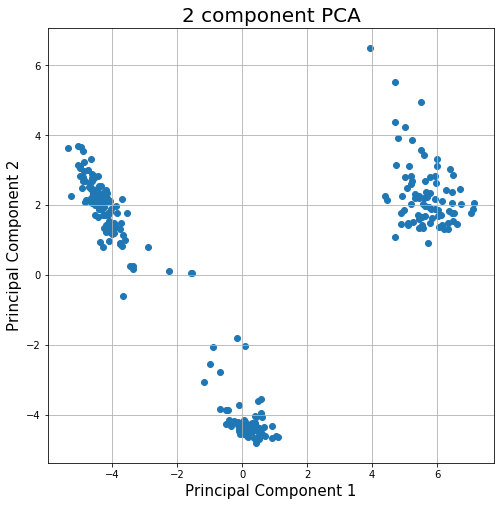

In [8]:
x = []

for batch in reprs:
    for obj in batch:
        x.append(obj.tolist())
            
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)

pc1 = principalComponents[:, 0]
pc2 = principalComponents[:, 1]

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

ax.scatter(pc1, pc2)

ax.grid()

Estimated number of clusters: 3
Estimated number of noise points: 5
Homogeneity: 0.156
Completeness: 0.233
V-measure: 0.187
Adjusted Rand Index: 0.033
Adjusted Mutual Information: 0.166
Silhouette Coefficient: 0.608


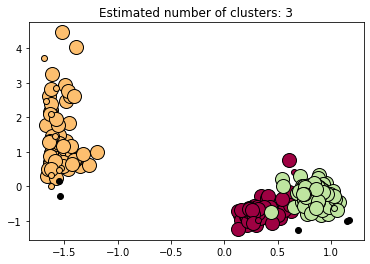

In [9]:
db = DBSCAN(eps=5, min_samples=20).fit(x)
labels_true = labels.flatten()
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
cluster_labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_noise_ = list(cluster_labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, cluster_labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, cluster_labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, cluster_labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, cluster_labels))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(labels_true, cluster_labels)
)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(x, cluster_labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(cluster_labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = cluster_labels == k

    xy = x[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = x[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

In [10]:
from PIL import Image

Randomly sampled images for idx 0


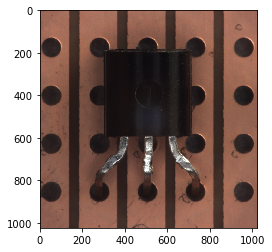

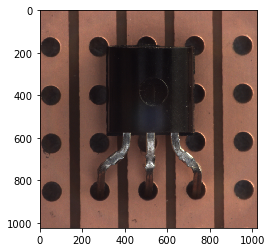

Randomly sampled images for idx 1


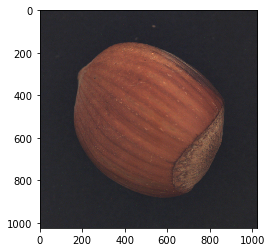

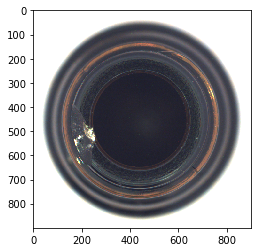

Randomly sampled images for idx 2


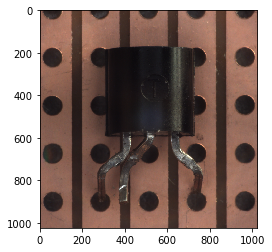

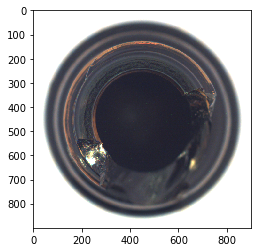

Randomly sampled images for idx -1


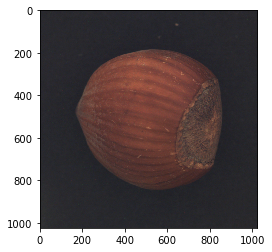

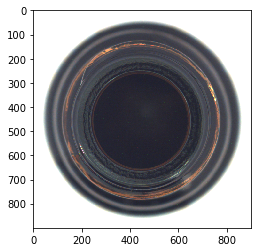

In [11]:
for l in set(cluster_labels):
    print(f"Randomly sampled images for idx {l}")
    for idx in np.random.choice(np.argwhere(cluster_labels == l).flatten(), 2):
        img = np.asarray(Image.open(mvtec_loader.test_img_list[idx]).convert("RGB"))
        plt.imshow(img)
        plt.show()

For n_clusters = 2 The average silhouette_score is : 0.4764678224664984
For n_clusters = 3 The average silhouette_score is : 0.6084732714851268
For n_clusters = 4 The average silhouette_score is : 0.530041039328505
For n_clusters = 5 The average silhouette_score is : 0.48044908932482655
For n_clusters = 6 The average silhouette_score is : 0.29956848785977963
For n_clusters = 7 The average silhouette_score is : 0.25492571274773274
For n_clusters = 8 The average silhouette_score is : 0.3098079041585895


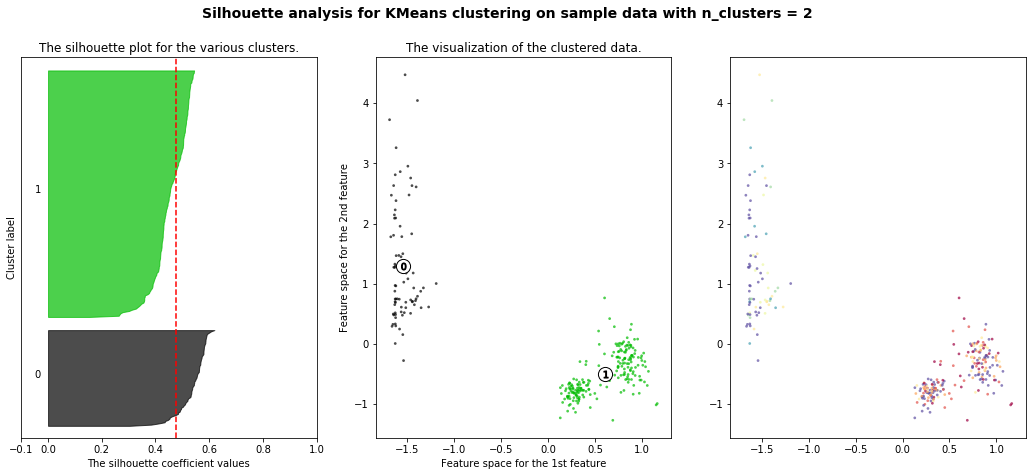

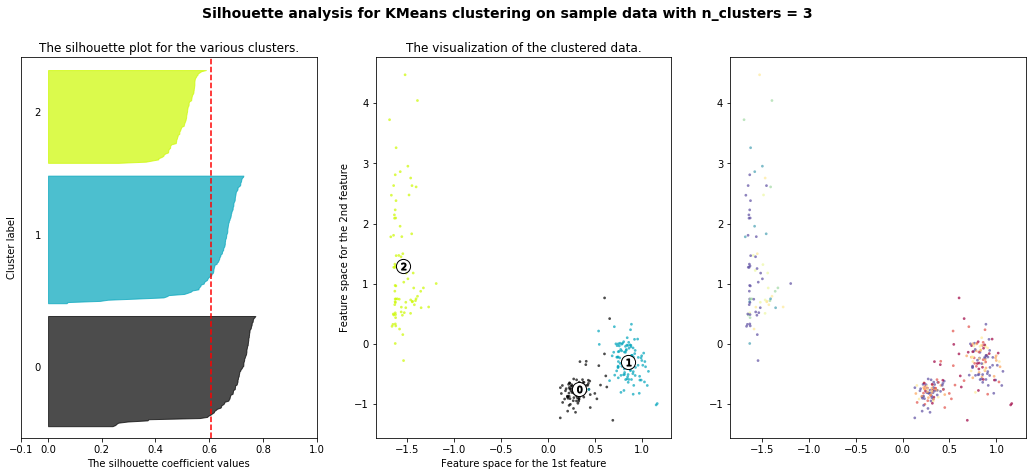

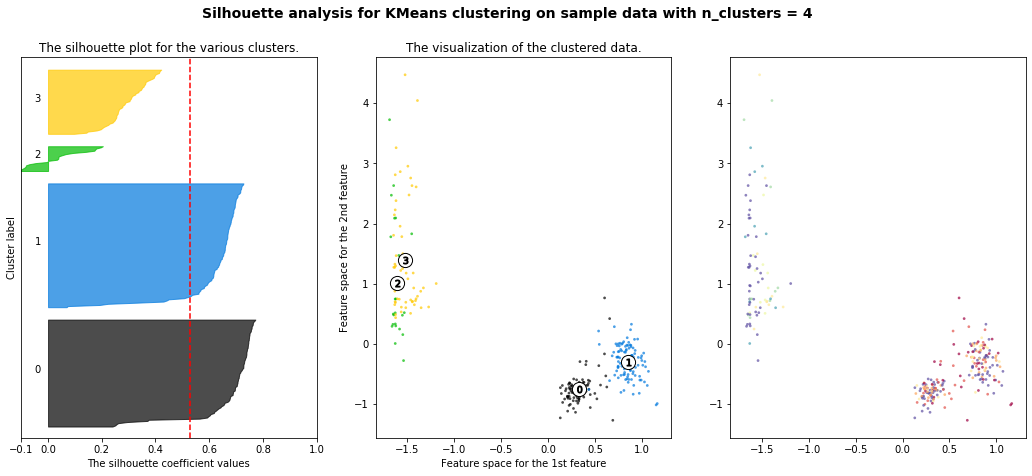

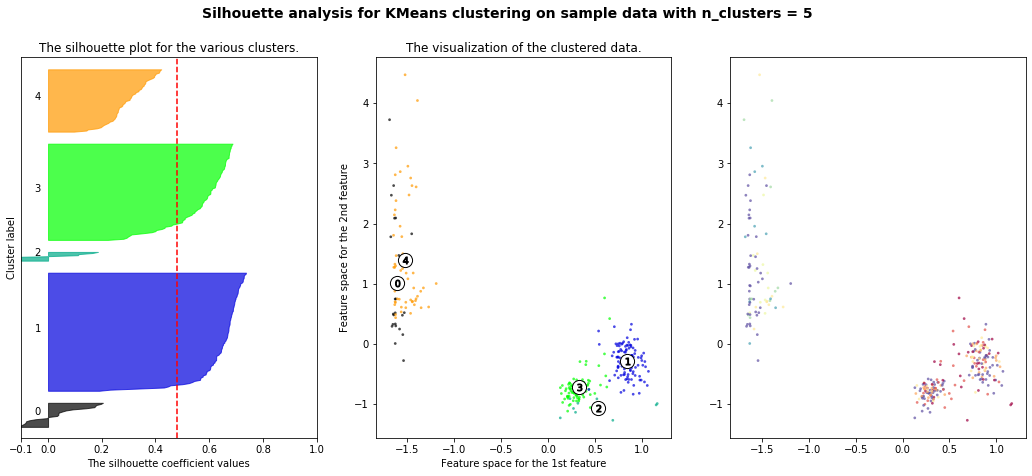

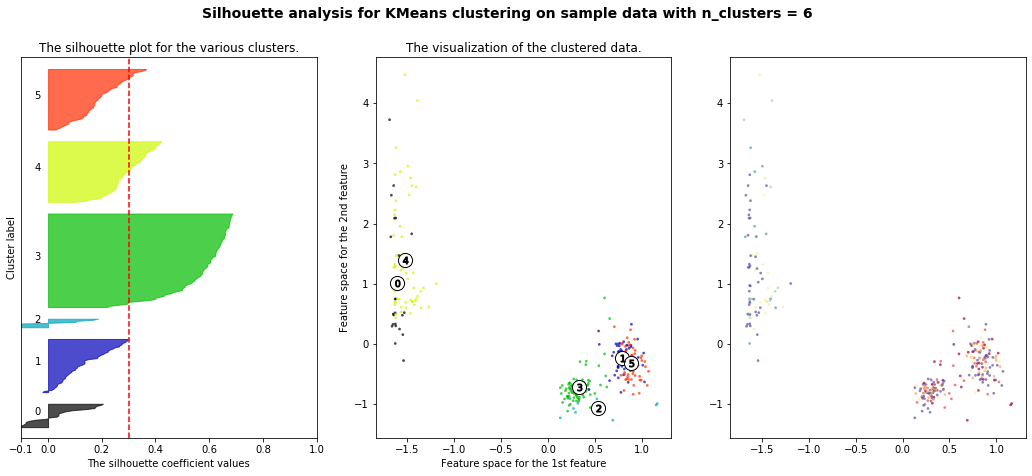

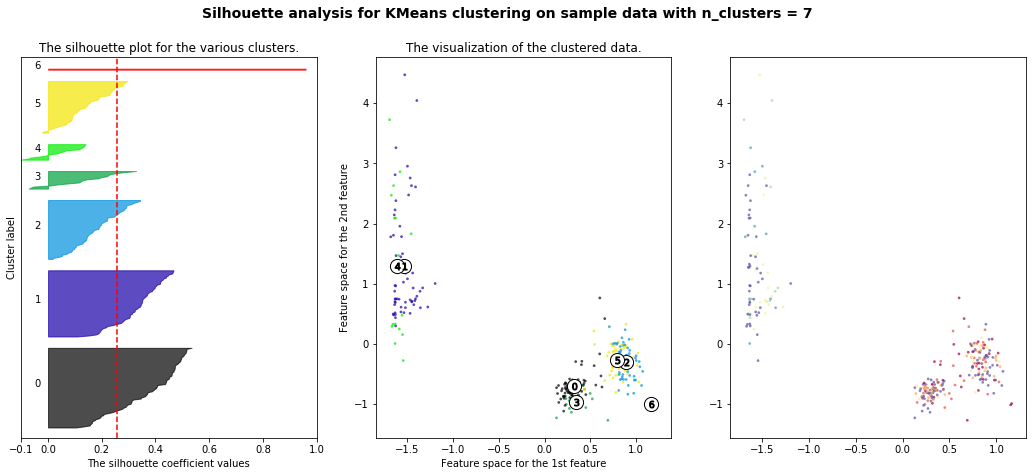

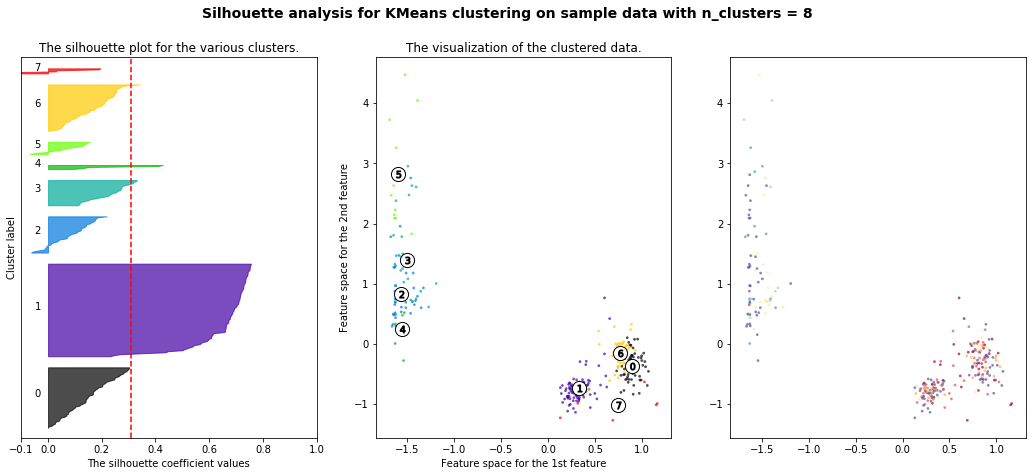

In [12]:
X, y = x, labels_true

range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    

    color_map = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(set(labels_true)))]
    ax3.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=[color_map[i - 1] for i in labels_true], edgecolor="k"
    )


    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

In [13]:
def SelBest(arr:list, X:int)->list:
    dx=np.argsort(arr)[:X]
    return arr[dx]

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        #print(np.sqrt(covariance).shape)
        a = 2 * np.sqrt(covariance)
        print(a.shape)
        width, height = a[0], a[1]
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))

def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    
    w_factor = 0.2 / gmm.weights_.max()
    #for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
    #    draw_ellipse(pos, covar, alpha=w * w_factor)
    plt.title("GMM with %d components"%len(gmm.means_), fontsize=(20))
    plt.xlabel("U.A.")
    plt.ylabel("U.A.")

Text(0, 0.5, 'Score')

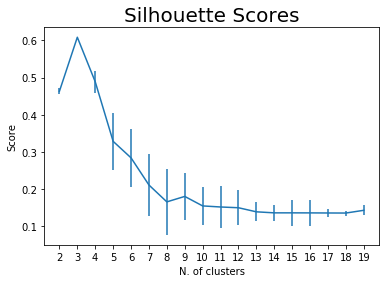

In [16]:
n_clusters=np.arange(2, 20)
sils=[]
sils_err=[]
iterations=20
for n in n_clusters:
    tmp_sil=[]
    for _ in range(iterations):
        gmm=GMM(n, n_init=2).fit(X) 
        labels=gmm.predict(X)
        sil=metrics.silhouette_score(X, labels, metric='euclidean')
        tmp_sil.append(sil)

    val=np.mean(SelBest(np.array(tmp_sil), int(iterations/5)))
    err=np.std(tmp_sil)
    sils.append(val)
    sils_err.append(err)

plt.errorbar(n_clusters, sils, yerr=sils_err)
plt.title("Silhouette Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")

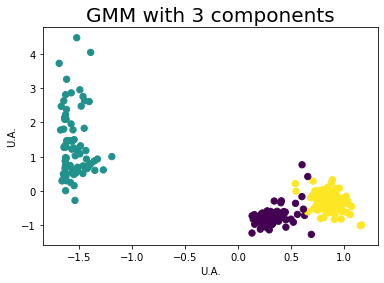

In [18]:
plot_gmm(GMM(3, n_init=2), X)

### Small AE

In [19]:
cfg = omegaconf.OmegaConf.load('../config/config.yaml')
cfg.arch.embedding_size = 8 
cfg.arch.cnn_enc.output_size = 8

model = AE.AE.load_from_checkpoint('./model_small_ae.ckpt', args=cfg)

In [20]:
transform  = tv.transforms.Compose([tv.transforms.ToPILImage(),
                                    #tv.transforms.Grayscale(num_output_channels=3),
                                    tv.transforms.Resize((cfg.arch.cnn_enc.input_height, cfg.arch.cnn_enc.input_width)),
                                    tv.transforms.ToTensor(), 
                                    #tv.transforms.Normalize((0.5,), (0.5,))
                                   ])

mvtec_loader = mloader.MVTecADDataset(data_root='../data/mvtec_anomaly_detection', 
                                      results_root=os.path.join('../', cfg.exp.results_path, '_' + cfg.exp.run_id),
                                      targets=['bottle', 'transistor', 'hazelnut'], 
                                      create_or_load=True,
                                      reprod=True,
                                      idx_file='idx_' + cfg.exp.run_id, #+ '_split.pkl',
                                      targets_file='targets_' + cfg.exp.run_id, # + '.pkl',
                                      transforms=transform,
                                      batch_size=cfg.exp.batch_size,
                                      val_ratio=0.0,
                                      num_workers=cfg.data.num_workers)

targets to be used are:  hazelnut,transistor,bottle


In [21]:
reprs, labels = utils.get_representations(model, mvtec_loader.test_dataloader())

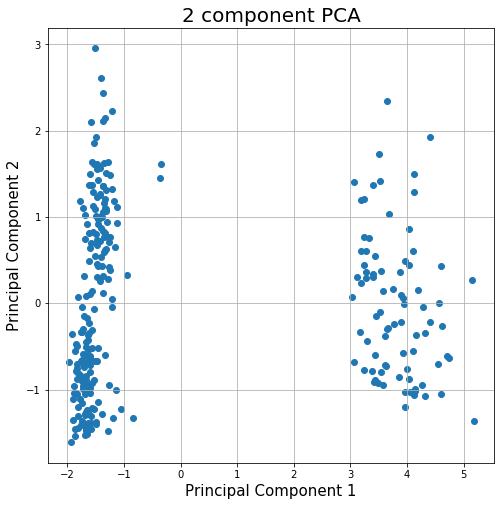

In [22]:
x = []

for batch in reprs:
    for obj in batch:
        x.append(obj.tolist())
            
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)

pc1 = principalComponents[:, 0]
pc2 = principalComponents[:, 1]

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

ax.scatter(pc1, pc2)

ax.grid()

Estimated number of clusters: 2
Estimated number of noise points: 0
Homogeneity: 0.146
Completeness: 0.419
V-measure: 0.217
Adjusted Rand Index: 0.032
Adjusted Mutual Information: 0.208
Silhouette Coefficient: 0.688


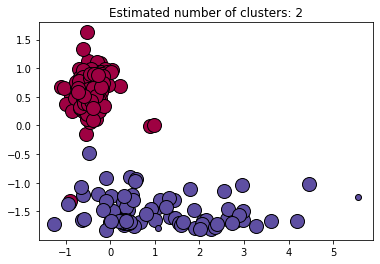

In [23]:
db = DBSCAN(eps=2.5, min_samples=10).fit(x)
labels_true = list(labels.flatten())
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
cluster_labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_noise_ = list(cluster_labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, cluster_labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, cluster_labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, cluster_labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, cluster_labels))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(labels_true, cluster_labels)
)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(x, cluster_labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(cluster_labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = cluster_labels == k

    xy = x[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = x[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.6875863216791713
For n_clusters = 3 The average silhouette_score is : 0.565653250229087
For n_clusters = 4 The average silhouette_score is : 0.5025362829928577
For n_clusters = 5 The average silhouette_score is : 0.4972827784622608
For n_clusters = 6 The average silhouette_score is : 0.5037080810627798
For n_clusters = 7 The average silhouette_score is : 0.39667637521035526
For n_clusters = 8 The average silhouette_score is : 0.4061699680919298


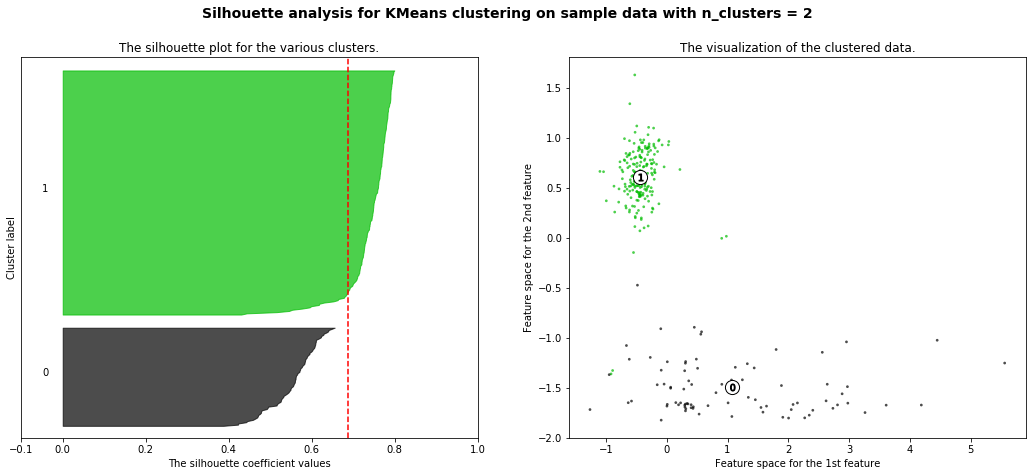

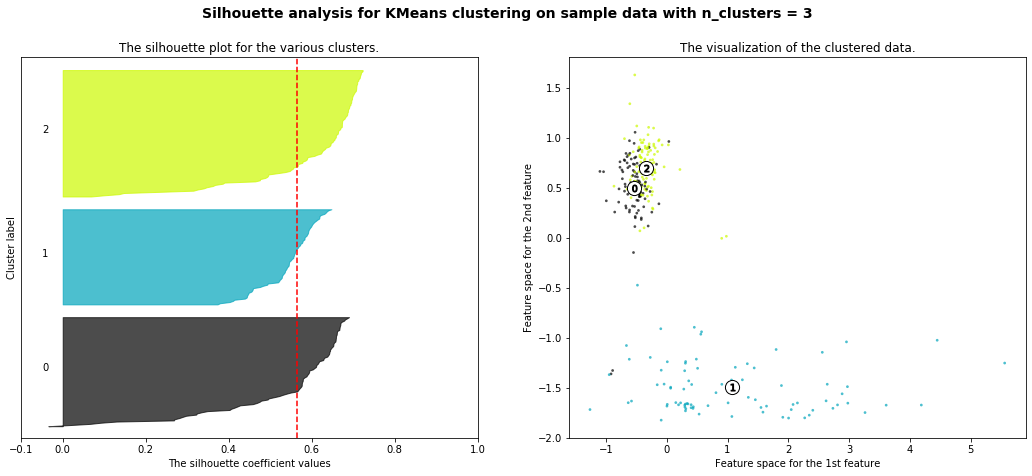

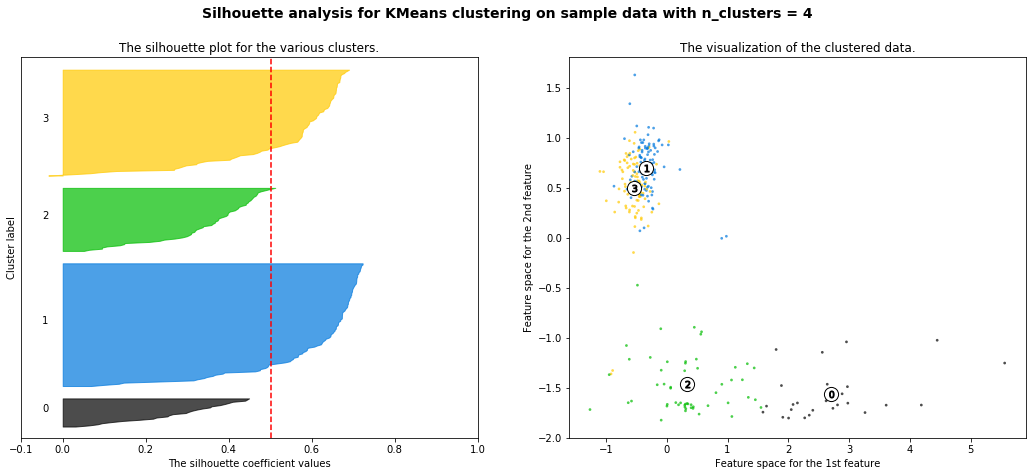

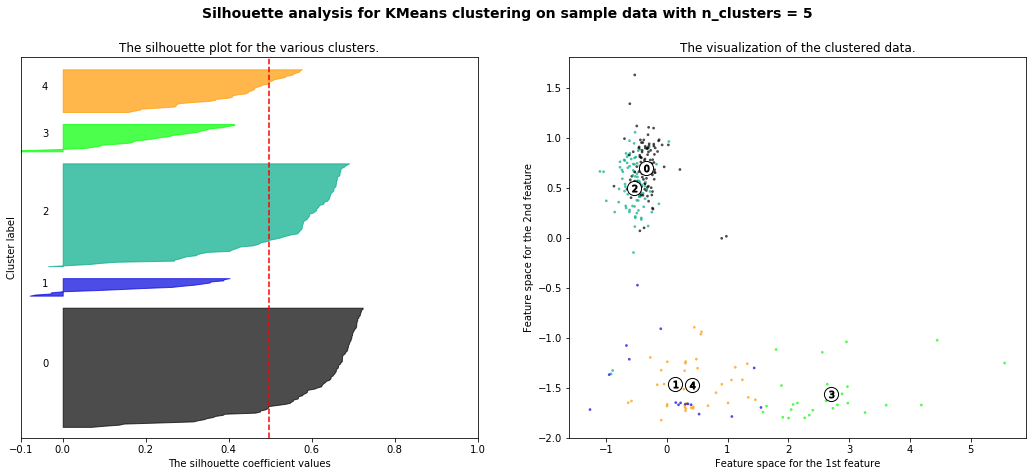

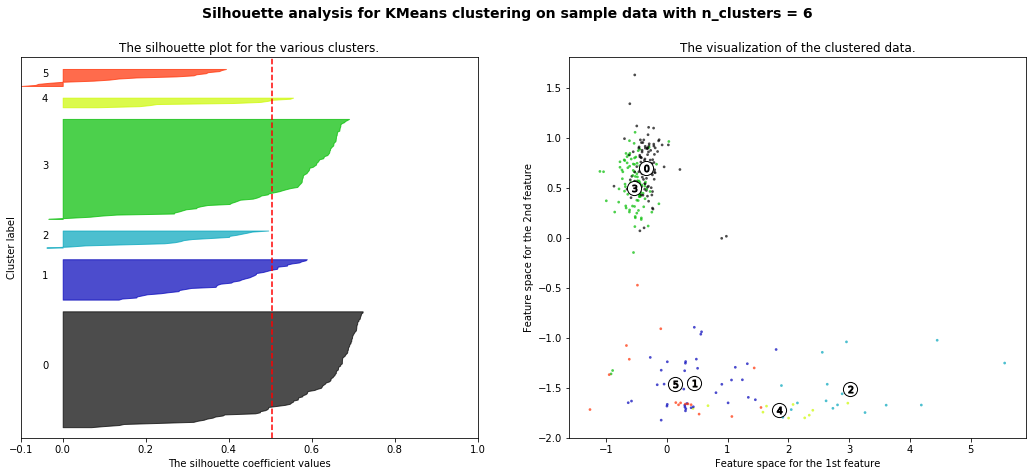

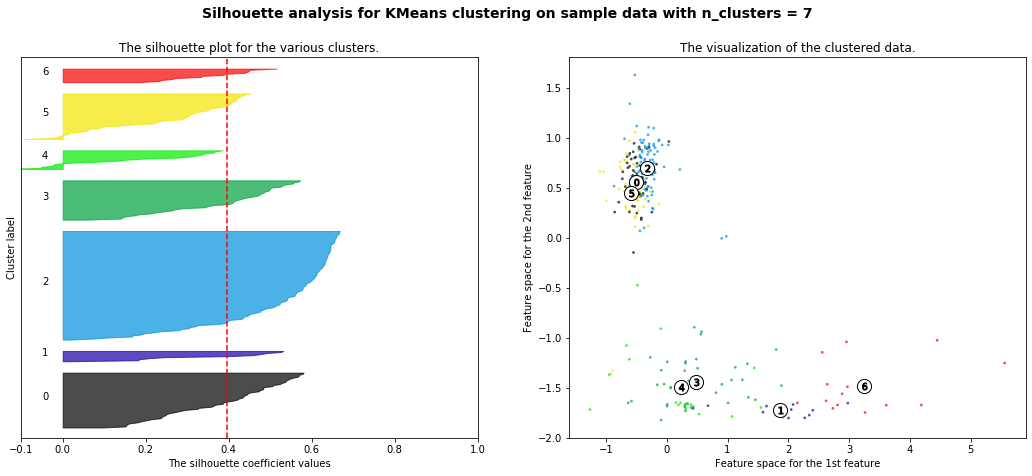

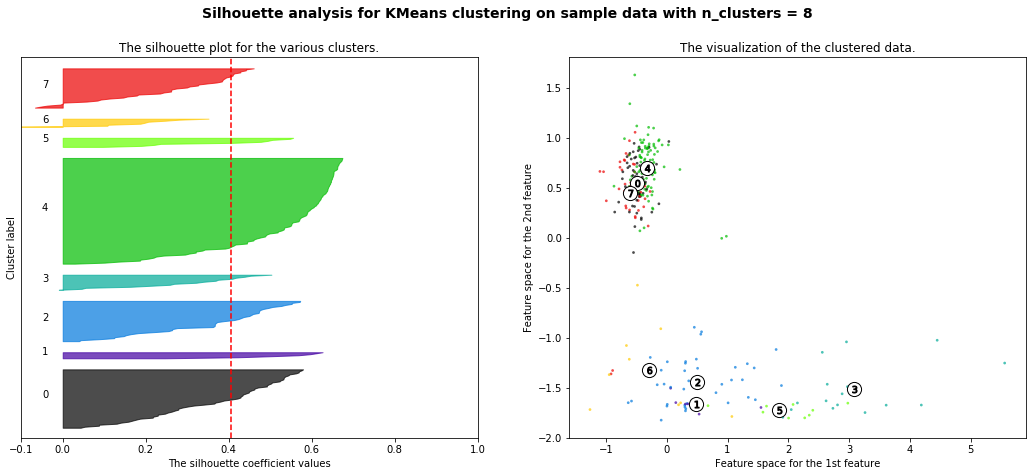

In [24]:
X, y = x, labels_true

range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

Text(0, 0.5, 'Score')

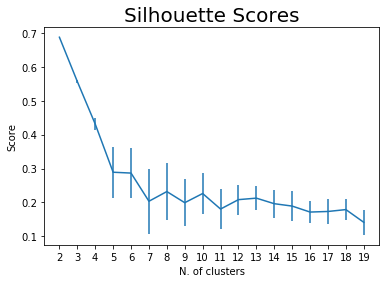

In [25]:
n_clusters=np.arange(2, 20)
sils=[]
sils_err=[]
iterations=20
for n in n_clusters:
    tmp_sil=[]
    for _ in range(iterations):
        gmm=GMM(n, n_init=2).fit(X) 
        labels=gmm.predict(X)
        sil=metrics.silhouette_score(X, labels, metric='euclidean')
        tmp_sil.append(sil)

    val=np.mean(SelBest(np.array(tmp_sil), int(iterations/5)))
    err=np.std(tmp_sil)
    sils.append(val)
    sils_err.append(err)

plt.errorbar(n_clusters, sils, yerr=sils_err)
plt.title("Silhouette Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")

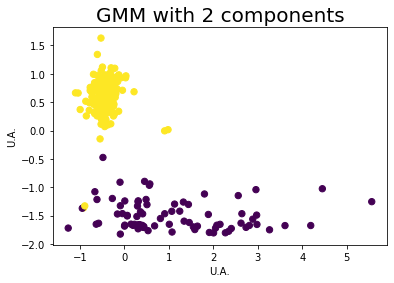

In [26]:
plot_gmm(GMM(2, n_init=2), X)